# The Machinery

For proof of concept, I consider Gaussian generative models with MLP discriminator. The Gaussian generative models take data from n-dimensional latent space $z \sim \mathcal{N}(0, I)$ to arbitrary n-dimensional $\mathcal{N}(\mu, \Sigma)$ by learned affine transformation.

In [2]:
import numpy as np
import theano as theano
import theano.tensor as T

/home/hudson/.local/lib/python3.5/site-packages/theano/gpuarray/dnn.py:135: UserWarning: Your cuDNN version is more recent than Theano. If you encounter problems, try updating Theano or downgrading cuDNN to version 5.1.
  warnings.warn("Your cuDNN version is more recent than "
Using cuDNN version 6020 on context None
Mapped name None to device cuda0: GeForce GTX 1080 (0000:02:00.0)


In [3]:
from matplotlib import pyplot as plt
%matplotlib inline

In [4]:
import sys
sys.path.append('/home/hudson/Projects/GAMM')
from lib.utils import log_progress

## Generator

In [5]:
class GaussianGenerator(object):
    def __init__(self, ndim= 1, mu=None, sig=None, scale=1):
        if mu is None:
            mu = scale*np.random.randn(ndim,)
        mu = theano.shared(value=mu, name='mu', borrow=True)
        if sig is None:
            sig = np.random.randn(ndim, ndim)
        sig = theano.shared(value=sig, name='sigma', borrow=True)
        self.mu = mu
        self.sig = sig
        
        ndim = mu.shape[0].eval()
        self.ndim = ndim
        
        self.params = [self.mu, self.sig]
        
    def sample(self, n=1):
        z = np.random.randn(self.ndim, n)
        out = (T.dot(self.sig, z).T + self.mu.T)
        return(out)

## Discriminator

In [6]:
class Hidden(object):
    #http://deeplearning.net/tutorial/mlp.html
    def __init__(self, input, n_in, n_out, W = None, b = None,
                 activation = T.tanh, rng = np.random.RandomState()):
        
        self.input = input
        
        if W is None:
            W_range = np.sqrt(6. / (n_in + n_out))
            W_values = np.asarray(
                rng.uniform(
                    low = -W_range,
                    high = W_range,
                    size=(n_in, n_out)
                ),
                dtype=theano.config.floatX
            )
            if activation == T.nnet.sigmoid:
                W_values *= 4
            W = theano.shared(value=W_values, name='W', borrow=True)

        if b is None:
            b_values = np.zeros((n_out,), dtype=theano.config.floatX)
            b = theano.shared(value=b_values, name='b', borrow=True)

        self.W = W
        self.b = b
        
        # parameters of the model
        self.params = [self.W, self.b]
        
        lin_output = T.dot(input, self.W) + self.b
        self.output = (
            lin_output if activation is None
            else activation(lin_output)
        )

In [7]:
class LogisticRegression(object):
    def __init__(self, input, n_in, n_out, W = None, b = None,
                 rng = np.random.RandomState()):
        
        self.input = input
        
        if W is None:
            W_range = np.sqrt(6. / (n_in + n_out))
            W_values = np.asarray(
                rng.uniform(
                    low = -W_range,
                    high = W_range,
                    size=(n_in, n_out)
                ),
                dtype=theano.config.floatX
            )
            W = theano.shared(value=W_values, name='W', borrow=True)

        if b is None:
            b_values = np.zeros((n_out,), dtype=theano.config.floatX)
            b = theano.shared(value=b_values, name='b', borrow=True)

        self.W = W
        self.b = b
        
        self.params = [self.W, self.b]
        
        self.p_y = T.nnet.softmax(T.dot(input, self.W) + b)
        self.y_pred = T.argmax(self.p_y, axis=1)

In [15]:
class MLP(object):
    def __init__(self, input, n_in, n_out, n_hidden=300, params = None,
                 rng = np.random.RandomState()):
        self.input = input
        self.n_in = n_in
        self.n_out = n_out
        self.n_hidden = n_hidden
        self.rng = rng
        
        hidden = Hidden(
            input,
            n_in, n_hidden,
            W = None if params is None else params[0],
            b = None if params is None else params[1],
            rng = rng
        )
        self.hidden = hidden
        
        softmax = LogisticRegression(
            self.hidden.output,
            n_hidden, n_out,
            W = None if params is None else params[2],
            b = None if params is None else params[3],
            rng = rng
        )
        self.softmax = softmax
        
        self.p_y = softmax.p_y
        self.y_pred = softmax.y_pred
        
        self.p_cluster = self.p_y[:,1:] / self.p_y[:,1:].sum(axis = 1)[:, np.newaxis]
        self.cluster_pred = T.argmax(self.p_cluster, axis=1)
        
        self.params = hidden.params + softmax.params
        
    def predict(self, x):
        mlp = MLP(x, self.n_in, self.n_out, self.n_hidden, self.params, self.rng)
        return(mlp.y_pred.eval())
        
    def cluster(self, x):
        mlp = MLP(x, self.n_in, self.n_out, self.n_hidden, self.params, self.rng)
        return(mlp.cluster_pred.eval())

# Bringing Softmax to GANs 

### Training the Discriminator:

Given 
* data $\mathbf{x} = x_1, ..., x_n$ distributed according to a mixture of k distributions, $p_x(x)$ 
* known latent distribution $z \sim p_z(z)$
* and k generative models $\mathbf{G}_1(z), ..., \mathbf{G}_k(z)$ with $\mathbf{G}_i(z) \sim p_{G_i}$,

we may consider a discriminative model $\mathbf{D}(x)$ which outputs a vector which *approximates* $<P(x \sim p_x), P(x \sim p_{G_1}), ..., P(x \sim p_{G_k})>$. 

I will denote the entries of this vector as 
$<D_x, D_{G_1}, ..., D_{G_k}>$.

To train $D$ for fixed $\{\mathbf{G}_i\}$, we may minimize the cross entropy loss:
$$-\mathbb{E}_x[P(x \sim p_x)log(D_x) + \sum_{G_i} P(x \sim p_{G_i})log D_{G_i}(x)]$$
Aligning ourselves with the GAN formulation by Goodefllow, *et al.*, we assign equal values to $\mathbb{E}_x[P(x \sim p_x)]$ and $\mathbb{E}_x[\sum_{G_i}P(x \sim p_{G_i})]$, yielding a cross entropy loss proportional to:
$$-\mathbb{E}_{x \sim p_x}[log D_x(x)] - \sum_{G_i} P(G_i) \mathbb{E}_{z \sim p_z}[log D_{G_i}(G_i(z))]$$
where $P(G_i) = \mathbb{E}_x[P(x \sim p_{G_i}) / \sum_{G_i}P(x \sim p_{G_i})]$, which is extimated by $\mathbb{E}_x[D_{G_i}(x) / \sum_{G_i}D_{G_i}(x)]$

### Training the Generator

##### Total Mixture Loss

We still wish to maximize the discriminator's probability of making a mistake between real and generated data (from a mixture of generators) as in the standard GAN. Maximize:
$$\mathcal{L} = -\mathbb{E}_{x \sim p_x}[log D_x(x)] - \mathbb{E}_{z \sim p_z}[log D_{G}(G(z))]$$
$$=-\mathbb{E}_{x \sim p_x}[log D_x(x)] - \sum_{G_i} P(G_i) \mathbb{E}_{z \sim p_z}[log D_{G}(G_i(z))]$$

where $D_{G}(x) = \sum_{G_i} D_{G_i}(x) = 1 - D_x(x)$ and $G(z)$ is a mixture of $\{G_i\}$ with mixture proportions $\{P(G_i)\}$, extimated by $\mathbb{E}_x[D_{G_i}(x) / \sum_{G_i}D_{G_i}(x)]$ as above




##### Individual Cluster Loss

We may instead choose to train each individual generator on the portion of the observed data that corresponds best to that generator (a la expectation maximization). For $G_i \in G_1, ..., G_k$, maximize:
$$\mathcal{L}_i = -\mathbb{E}_{x \sim p_{G_i}}[log \hat{D}_x (x)] - \mathbb{E}_{z \sim p_z(z)}[log \hat{D}_{G_i}(G_i(z))]$$
where $\hat{D}_x$ and $\hat{D}_{G_i}$ are the versions of $D_x$ and $D_{G_i}$ normalized to sum to 1 (marginal probabilities).

We may consider maximizing $\mathcal{L} = \sum_{i} \mathcal{L}$ since $\nabla_{G_i}\mathcal{L} = \nabla_{G_i}\mathcal{L}_i$:
$$\mathcal{L} = \sum_i -\mathbb{E}_{x \sim p_{G_i}}[log \hat{D}_x (x)] - \mathbb{E}_{z \sim p_z(z)}[log \hat{D}_{G_i}(G_i(z))]$$
$$\nabla_{G} \mathcal{L} = \nabla_{G} \sum_i  - \mathbb{E}_{z \sim p_z(z)}[log \hat{D}_{G_i}(G_i(z))]$$

## TODO: remark on relationship to EM

### Data

##### Distribution to fit. Mixture of Gaussians

In [9]:
n = 10000
mixture = np.array([1, 1, 1])
mixture = mixture/sum(mixture)
x = []
for proportion in mixture:
    g = GaussianGenerator(ndim=2, scale = len(mixture)**2)
    z = g.sample(int(proportion * n)).eval()
    x.append(z)
x = np.vstack(x).astype('float32')

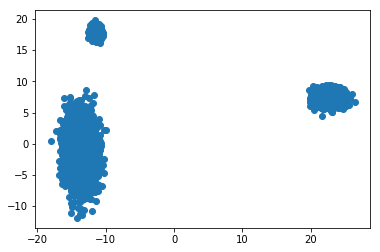

In [10]:
plt.scatter(x[:,0], x[:,1])

### Model fitting

In [11]:
def plotDecision(X, model, h=.05):
    # X - some data in 2dimensional np.array
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))

    # here "model" is your model's prediction (classification) function
    Z = model(np.c_[xx.ravel(), yy.ravel()]) 

    # Put the result into a color plot
    Z = Z.reshape(xx.shape)
    plt.contourf(xx, yy, Z, cmap=plt.cm.Paired)
    #plt.axis('off')

In [12]:
def gradDesc(cost, params, lr=.00005):
    grads = T.grad(cost=cost, wrt=params)
    updates = []
    for p, g in zip(params, grads):
        update = p - lr * g
        updates.append((p, update))
    return updates

In [22]:
def mixtureTrain(X, k, batch_size = 100, iters = 400, alpha = .005,
         rng = np.random.RandomState()):
    x = T.matrix('x')
    
    #Set up model
    gens = [GaussianGenerator(ndim=2, scale = k**2)
            for i in range(k)]
    #genParams = [gen.params for gen in gens]
    genParams = gens[0].params
    for gen in gens[1:]:
        genParams = genParams + gen.params
    
    dataCrit = MLP(x, X.shape[1], k+1, n_hidden = 300)
    critParams = dataCrit.params
    genCrits = [MLP(gens[i].sample(batch_size), #use full batch size
                    X.shape[1], k+1, n_hidden = 300, 
                    params = critParams) #params must be shared
                for i in range(len(gens))
               ]
    
    #Estimate mixture
    mixture = T.mean(dataCrit.p_y[:,1:] \
                     / dataCrit.p_y[:,1:].sum(axis = 1)[:, np.newaxis], 
                     axis = 0)
    #Exclude mixture estimate from theano graph. 
    #We do not want to compute or use its gradients 
    mixture = theano.gradient.disconnected_grad(mixture)
    
    computeMixture = theano.function(inputs = [x], outputs = mixture)
    
    #Set up optimization
    #Critic
    critLoss = -T.mean(T.log(dataCrit.p_y[:,0])) \
                -T.sum(
                    [
                        mixture[i] * T.mean(T.log(genCrits[i].p_y[:,i+1]))
                        for i in range(k) 
                    ]
                )
    critUpdates = gradDesc(critLoss, critParams, lr=alpha)
    trainCrit = theano.function(
            inputs = [x],
            outputs = critLoss,
            updates = critUpdates
        )
    
    #Generator (Total mixture)
    
    genLoss = T.sum(
                    [
                        T.mean(T.log(genCrits[i].p_y[:,i+1]/T.sum(genCrits[i].p_y[:,[0,i+1]], axis = 1)))
                        for i in range(k) 
                    ]
                )
    genUpdates = gradDesc(genLoss, genParams, lr=alpha) 
    
    trainGen = theano.function(
            inputs = [],
            outputs = genLoss,
            updates = genUpdates
        )

    
    print("\nBegin training...")
    
    #Plot of initial model
    gX = []
    gY = []
    for i in range(k):
        g = gens[i]
        z = g.sample(int(n/k)).eval()
        gX.append(z)
    gX = np.vstack(gX)

    plt.figure()
    plt.scatter(X[:,0], X[:,1])
    plt.scatter(gX[:,0], gX[:,1])
    plt.show()
    
    #Train
    crit_losses = []
    gen_losses = []
    for i in log_progress(range(iters), every = 1, name = "Iteration"):
        crit_loss = trainCrit(
            X[rng.randint(X.shape[0], size=batch_size)]
        )
        gen_loss = trainGen()
        crit_losses.append(crit_loss)
        gen_losses.append(gen_loss)
        
        if i in [1, 10, 5000, 10000, 30000, 50000, 80000, 100000, 120000, 150000, 180000]:
            gX = []
            gY = []
            for j in range(k):
                g = gens[j]
                z = g.sample(int(np.floor(computeMixture(X)[j] * n))).eval()
                gX.append(z)
            gX = np.vstack(gX)

            plt.figure()
            plt.title(i)
            plotDecision(np.vstack((X, gX)), dataCrit.cluster)
            plt.scatter(X[:,0], X[:,1])
            plt.scatter(gX[:,0], gX[:,1])
            plt.show()
    plt.figure()
    plt.plot(crit_losses)
    plt.plot(gen_losses)
    
    #Plot of final model
    gX = []
    gY = []
    for i in range(k):
        g = gens[i]
        z = g.sample(int(np.floor(computeMixture(X)[i] * n))).eval()
        gX.append(z)
    gX = np.vstack(gX)

    plt.figure()
    plotDecision(np.vstack((X, gX)), dataCrit.predict)
    plt.scatter(X[:,0], X[:,1])
    plt.scatter(gX[:,0], gX[:,1])
    plt.show()
    
    return(critParams, gens, computeMixture(X))


Begin training...


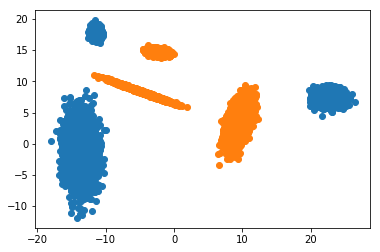

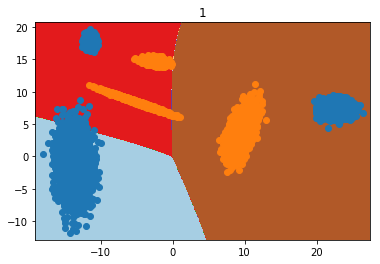

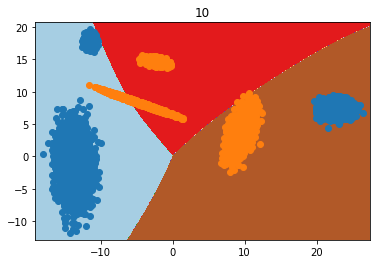

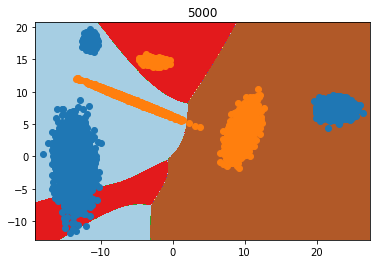

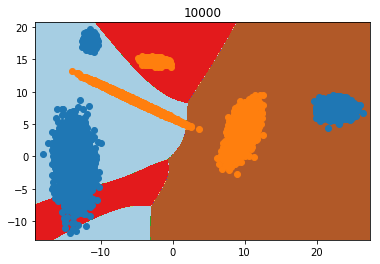

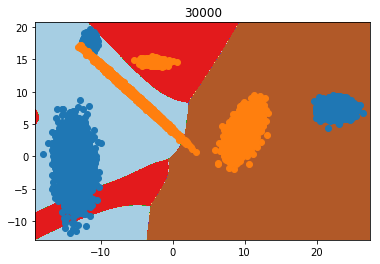

GpuArrayException: b'out of memory'
Apply node that caused the error: GpuFromHost<None>(dot.0)
Toposort index: 4
Inputs types: [TensorType(float64, matrix)]
Inputs shapes: [(1206282, 300)]
Inputs strides: [(2400, 8)]
Inputs values: ['not shown']
Outputs clients: [[GpuElemwise{Composite{tanh((i0 + i1))}}[(0, 0)]<gpuarray>(GpuFromHost<None>.0, InplaceGpuDimShuffle{x,0}.0)]]

HINT: Re-running with most Theano optimization disabled could give you a back-trace of when this node was created. This can be done with by setting the Theano flag 'optimizer=fast_compile'. If that does not work, Theano optimizations can be disabled with 'optimizer=None'.
HINT: Use the Theano flag 'exception_verbosity=high' for a debugprint and storage map footprint of this apply node.

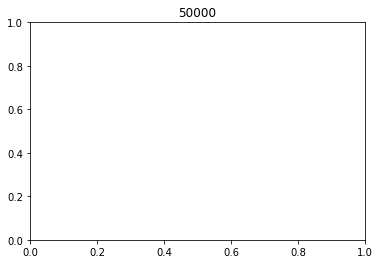

In [23]:
critParams, gens, mixture = mixtureTrain(x, 3, iters = 200000)

In [ ]:
print(mixture)